# FIFA voetbal

In deze studie zullen Wail Abou, Bart de Vries en Youssef Boulfiham een aantal onderwerpen over FIFA onderzoeken. Voor dit onderzoek zullen we te werk gaan met datasets over voetbalspelers en voetbalwedstrijden uit het seizoen 2019-2020 Met behulp van statistische analyse zullen we trachten om tot nieuwe ontdekkingen en conclusies te komen.

### Onderzoeksvragen
1. In hoeverre is de prijs van een speler te voorspellen aan de hand van zijn belangrijkste kenmerken?
- Kan je op basis van de gemiddelde waardes van een team voorspellen welke van de 2 teams zullen winnen?
-In hoeverre heeft de leeftijd van een speler invloed op zijn prijswaarde.
- Is er een verband tussen de lengte en de positie van een speler.
- Is er een verband tussen de lengte en de kop kwaliteiten van een speler.
- Welke kwaliteiten van een speler zijn het sterkst ontwikkelt vergeleken met de gemiddelde kwaliteiten van de eerste selectie van de desbetreffende speler zijn team.
- Kunnen we een accurate schatting maken van de gemiddelde waardes van een speler op basis van zijn prijs.

### Databases die zullen worden gebruikt
- FIFA-spelerseigenschappen van seizoen 2019-2020
- FIFA-wedstrijd uitslagen van seizoen 2019-2020

### Verwachte resultaat
- Nieuwe inzichtingen over de prijs en kwaliteit verhoudingen van de spelers.
- Voorspellingen van wedstrijden en slagingspercentage van deze wedstrijden.
- Invloed van bepaalde specifieke factoren op de prijs bepaling van spelers.

In [3]:
# importeer libraries.
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import csv, glob, os

In [4]:
# .csv bestand uitlezen en omzetten naar pandas array van 18207x89
players = pd.read_csv('csv/fifa19.csv')

# selecteren van relevante gegevens
players = players[["Name", "Nationality", "Overall", "Potential", "Club", "Value", "Height",
                   "Weight", "Age", "Position","Crossing", "Finishing", "HeadingAccuracy","ShortPassing",
                   'Volleys', "Dribbling", "Curve", "FKAccuracy", "LongPassing", "BallControl",
                   "Acceleration", "SprintSpeed", "Agility", "Reactions", "Balance", "ShotPower",
                   "Jumping", "Stamina", "Strength", "LongShots", "Aggression", "Interceptions",
                   "Positioning", "Vision", "Penalties","Composure", "Marking", "StandingTackle",
                   "SlidingTackle", "GKDiving", "GKHandling", "GKKicking", "GKPositioning", "GKReflexes"]]
players

,Name,Nationality,Overall,Potential,Club,Value,Height,Weight,Age,Position,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,L. Messi,Argentina,94,94,FC Barcelona,€110.5M,5'7,159lbs,31,RF,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,Cristiano Ronaldo,Portugal,94,94,Juventus,€77M,6'2,183lbs,33,ST,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,Neymar Jr,Brazil,92,93,Paris Saint-Germain,€118.5M,5'9,150lbs,26,LW,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,De Gea,Spain,91,93,Manchester United,€72M,6'4,168lbs,27,GK,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,K. De Bruyne,Belgium,91,92,Manchester City,€102M,5'11,154lbs,27,RCM,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,J. Lundstram,England,47,65,Crewe Alexandra,€60K,5'9,134lbs,19,CM,...,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0
18203,N. Christoffersson,Sweden,47,63,Trelleborgs FF,€60K,6'3,170lbs,19,ST,...,43.0,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0
18204,B. Worman,England,47,67,Cambridge United,€60K,5'8,148lbs,16,ST,...,55.0,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0
18205,D. Walker-Rice,England,47,66,Tranmere Rovers,€60K,5'10,154lbs,17,RW,...,50.0,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0


Hierboven kan je een deel van de dataset inzien. Zo kan je zien met welke kolommen we zullen werken, welke meetwaardes we zullen gebruiken en hoeveel data elementen er beschikbaar is.

In de onderstaande grafiek kan je de frequentieverdeling aflezen van de gemiddelde kwaliteit van de spelers.

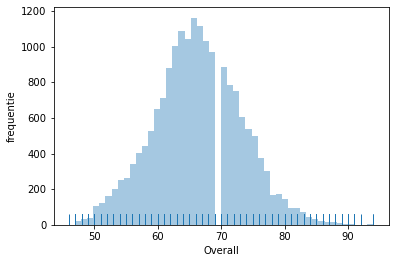

In [5]:
# frequentieverdeling
ax = sns.distplot(players.Overall, kde=False, rug=True)
ax = ax.set(xlabel='Overall', ylabel='frequentie')

<ipython-input-6-b86d59fdb323>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  sp = plt.subplot(3, 3, 1, polar=True)


Text(0.5, 1.1, 'Cristiano Ronaldo vs G. Nugent')

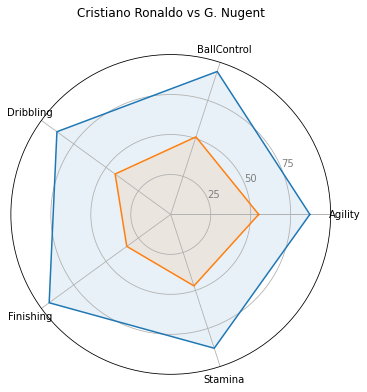

In [6]:
# Alleen relevante data selecteren en de beste en slechtste speler
player_skills = ['Name', 'Agility', 'BallControl', 'Dribbling', 'Finishing','Stamina']
best_worst = players.iloc[[1, -1]][player_skills]
best_worst = best_worst.set_index('Name')

plt.figure(figsize=(20, 20))
for name, skills in best_worst.iterrows():
    categories = skills.index.values

    # Alle punten om te tekenen
    points = list(skills.values)
    points += points[:1]

    # Alle hoeken berekenen
    angles = [side / float(len(categories)) * 2 * np.pi for side in range(len(categories))]
    angles += angles[:1]

    # De spider plot aanmaken
    sp = plt.subplot(3, 3, 1, polar=True)

    # De categorieen weergeven
    plt.xticks(angles, categories)

    # De markers weergeven
    plt.yticks([25, 50, 75], ["25", "50", "75"], color="grey")
    plt.ylim(0,100)
        
    # Alles plotten en opvullen
    sp.plot(angles, points)
    sp.fill(angles, points, alpha=0.1)
    

names = best_worst.index.values
plt.title(f'{names[0]} vs {names[1]}', y=1.1)

Met behulp van de bovenstaande grafiek stellen we ons in staat om in een oogopslag de kernkwaliteiten van de spelers in te zien en te vergelijken.

In [7]:
# Alle files via de path krijgen
path = r'westrijden'     
all_files = glob.glob(os.path.join(path, "*.csv"))

# Alle files in een dataframe inlezen via een list comprehension
data_frames = (pd.read_csv(f, encoding='cp1252', sep=';') for f in all_files)
clubs = pd.concat(data_frames, ignore_index=True)

# Relevanten kollommen selecteren
clubs = clubs[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]]

# De date omzetten naar de date object van panda
clubs.Date = pd.to_datetime(clubs.Date)

# De entries droppen die onder 2019 vallen
clubs = clubs.drop(clubs[clubs.Date < pd.Timestamp(2019, 1, 1)].index)

# Nieuwe kollom maken met de winnende team
clubs["WinningTeam"] = np.where(clubs["FTHG"] >= clubs["FTAG"], clubs["HomeTeam"], clubs["AwayTeam"])

clubs

,Date,HomeTeam,AwayTeam,FTHG,FTAG,WinningTeam
168,2019-01-18,Sint-Truidense VV,KRC Genk,2,3,KRC Genk
169,2019-01-19,KAS Eupen,Sporting Lokeren,4,1,KAS Eupen
170,2019-01-19,Standard de Liège,KV Kortrijk,2,1,Standard de Liège
171,2019-01-19,Waasland-Beveren,KSV Cercle Brugge,1,1,Waasland-Beveren
172,2019-01-19,SV Zulte-Waregem,Royal Antwerp FC,1,2,Royal Antwerp FC
...,...,...,...,...,...,...
2979,2019-12-05,Liverpool,Wolverhampton Wanderers,2,0,Liverpool
2980,2019-12-05,Manchester United,Cardiff City,0,2,Cardiff City
2981,2019-12-05,Southampton,Huddersfield Town,1,1,Southampton
2982,2019-12-05,Tottenham Hotspur,Everton,2,2,Tottenham Hotspur
